In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv(r"C:\Users\HP\Downloads\new_train_sample\new_train_sample.csv")
print(f"train_df: {train_df.head()}")


train_df:    Unnamed: 0             Id  OrgId  IncidentId  AlertId  \
0     5172780  1709396985476     26       18583   687462   
1     8470561   927712939180     33        5065     3990   
2     5897583  1090921697002    201      150787   807590   
3     3288552  1434519079555    204      108287    28575   
4     4060961  1005022347708     54      528202  1458226   

                  Timestamp  DetectorId  AlertTitle            Category  \
0  2024-06-06T05:56:47.000Z          31         813             Malware   
1  2024-06-03T10:45:09.000Z          38          25              Impact   
2  2024-06-13T03:36:40.000Z         419         444           Execution   
3  2024-06-08T16:54:57.000Z          44        1233  SuspiciousActivity   
4  2024-06-09T02:48:01.000Z         102       58829        Exfiltration   

                                     MitreTechniques  ... ResourceType  \
0                                                NaN  ...          NaN   
1                             

In [4]:
test_df = pd.read_csv(r"C:\Users\HP\Downloads\GUIDE_Test\GUIDE_Test.csv", low_memory=False)
print(f"test_df: {test_df.head()}")
# print(f"test_df info: {test_df.info()}")

test_df:               Id  OrgId  IncidentId  AlertId                 Timestamp  \
0  1245540519230    657       11767    87199  2024-06-04T22:56:27.000Z   
1  1400159342154      3       91158   632273  2024-06-03T12:58:26.000Z   
2  1279900255923    145       32247   131719  2024-06-08T03:20:49.000Z   
3    60129547292    222       15294   917686  2024-06-12T12:07:31.000Z   
4   515396080539    363        7615     5944  2024-06-06T17:42:05.000Z   

   DetectorId  AlertTitle           Category                  MitreTechniques  \
0         524         563    LateralMovement      T1021;T1047;T1105;T1569.002   
1           2           2  CommandAndControl                              NaN   
2        2932       10807    LateralMovement  T1021;T1027.002;T1027.005;T1105   
3           0           0      InitialAccess                  T1078;T1078.004   
4          27          18          Discovery                  T1087;T1087.002   

    IncidentGrade  ...       Roles OSFamily OSVersion Antis

In [5]:
train_df.fillna(train_df.mode().iloc[0], inplace=True)
test_df.fillna(train_df.mode().iloc[0], inplace=True)


In [6]:
num_data_points = train_df.shape[0]
num_data_points = test_df.shape[0]
print("Number of train_df data points:", num_data_points)
print("Number of test_df data points:", num_data_points)

Number of train_df data points: 4147992
Number of test_df data points: 4147992


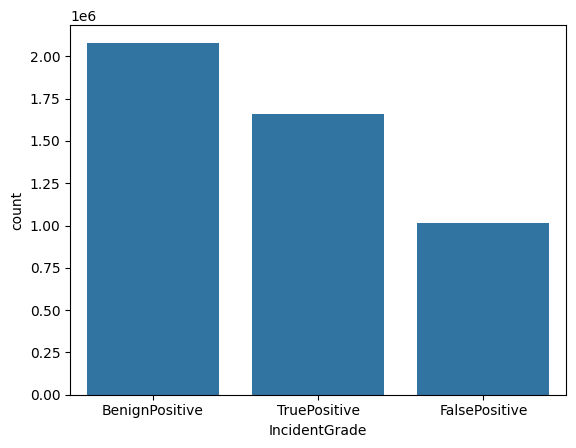

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_df, x='IncidentGrade')
plt.show()

# Split the dataset, taking 80% for training and 20% for testing


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

columns_to_keep = [
    'IncidentId',
    'AlertId',
    'Category',
    'IncidentGrade',
    'EntityType',
    'EvidenceRole',
    'DeviceId',
    'IpAddress',
    'ThreatFamily',
    'ResourceType',
    'AccountName',
    'MitreTechniques',
    'OSVersion',
    'AlertTitle',
    'CountryCode', 
    'State', 
    'City'
]

train_df_reduced = train_df[columns_to_keep].copy() 
test_df_reduced = test_df[columns_to_keep].copy() 

categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'ThreatFamily', 'ResourceType', 'MitreTechniques']

encoders = {}
for col in categorical_columns:
    top_3_values = train_df_reduced[col].value_counts().nlargest(3).index
    train_df_reduced[col] = train_df_reduced[col].apply(lambda x: x if x in top_3_values else "Others")
    test_df_reduced[col] = test_df_reduced[col].apply(lambda x: x if x in top_3_values else "Others")
    encoder = LabelEncoder()
    train_df_reduced[col] = encoder.fit_transform(train_df_reduced[col])
    test_df_reduced[col] = encoder.transform(test_df_reduced[col])
    encoders[col] = encoder

X = train_df_reduced.drop(columns=['IncidentGrade'])
y = train_df_reduced['IncidentGrade']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Confusion Matrix:
[[402758   5920   7172]
 [ 12800 186225   4189]
 [ 14989   4137 313494]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    415850
           1       0.95      0.92      0.93    203214
           2       0.97      0.94      0.95    332620

    accuracy                           0.95    951684
   macro avg       0.95      0.94      0.95    951684
weighted avg       0.95      0.95      0.95    951684



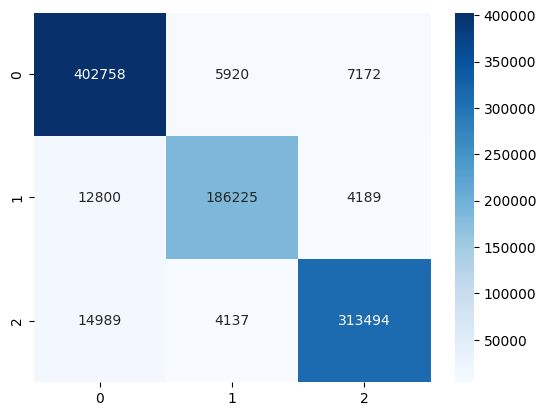

In [9]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

# Evaluation


In [10]:
y_test = test_df_reduced['IncidentGrade']
y_test_pred = model.predict(test_df_reduced.drop(columns=['IncidentGrade']))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

Test Confusion Matrix:
[[1504459  131734  116747]
 [ 165581  679918   57199]
 [ 177407   62688 1252259]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84   1752940
           1       0.78      0.75      0.77    902698
           2       0.88      0.84      0.86   1492354

    accuracy                           0.83   4147992
   macro avg       0.82      0.82      0.82   4147992
weighted avg       0.83      0.83      0.83   4147992

